# MNIST convolutional neural networks

* MNIST data를 가지고 **convolutional neural networks**를 만들어보자.
* reference codes
  * [tensorflow/tutorials/mnist_deep.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/tutorials/mnist/mnist_deep.py)
  * [cs20/examples/07_convnet_mnist.py](https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/07_convnet_mnist.py)

## Import modules

In [1]:
"""A very simple MNIST classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

### Show the MNIST

label = 5


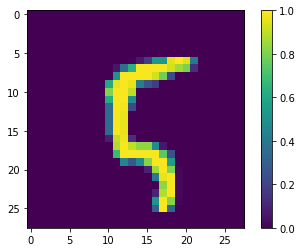

In [3]:
index = 100
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index])
plt.colorbar()
plt.gca().grid(False)
plt.show()

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count = max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


### Define Iterator

In [5]:
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
images, labels = iterator.get_next()
images = tf.cast(images, dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

## Build the model

In [6]:
class CnnMNIST(object):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels    
    self.num_classes = 10
    
  def inference(self, inputs):
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    # TODO
    self.inputs_images = tf.reshape(self.inputs, shape=[-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    # TODO
    conv1 = tf.layers.conv2d(inputs=self.inputs_images, 
                             filters=32, kernel_size=[5,5], padding='SAME', 
                             activation=tf.nn.relu, name='conv1')

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    # TODO
    pool1 = tf.layers.max_pooling2d(inputs=conv1,
                                   pool_size=[2,2], padding='SAME',
                                   strides=2, name='pool')

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    # TODO
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64,
                            kernel_size=[5,5], padding='SAME',
                            activation=tf.nn.relu, name='conv2')

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    # TODO
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, name='pool2')

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    # TODO
    dense = tf.layers.dense(pool2_flat, 1024, activation=tf.nn.relu, name='fc')

    # Add dropout operation; 0.6 probability that element will be kept
    self.is_training = tf.placeholder(tf.bool)
    self.keep_prob = tf.constant(0.6)    
    # TODO
    dropout = tf.layers.dropout(dense, self.keep_prob, training=self.is_training, name='dropout')

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    # TODO
    logits = tf.layers.dense(dropout, self.num_classes, name='logits')

    return logits
  
  def cross_entropy_loss(self, labels, logits):
    #y_one_hot = tf.one_hot(y, depth=10)
    #cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=y_pred)
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, scope='loss')    
    
    return cross_entropy
  
  def predictions(self):
    with tf.variable_scope('predictions'):
      predictions = tf.argmax(self.logits, 1)
      
      return predictions
      
  
  def build(self):
    self.global_step = tf.train.get_or_create_global_step()
    
    self.logits = self.inference(self.inputs)
    self.loss = self.cross_entropy_loss(self.labels, self.logits)
    self.predictions = self.predictions()
    
    print("complete model build.")

### Build the model

In [9]:
model = CnnMNIST(images, labels)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

complete model build.
---------
Variables: name (type shape) [size]
---------
conv1/kernel:0 (float32_ref 5x5x1x32) [800, bytes: 3200]
conv1/bias:0 (float32_ref 32) [32, bytes: 128]
conv2/kernel:0 (float32_ref 5x5x32x64) [51200, bytes: 204800]
conv2/bias:0 (float32_ref 64) [64, bytes: 256]
fc/kernel:0 (float32_ref 3136x1024) [3211264, bytes: 12845056]
fc/bias:0 (float32_ref 1024) [1024, bytes: 4096]
logits/kernel:0 (float32_ref 1024x10) [10240, bytes: 40960]
logits/bias:0 (float32_ref 10) [10, bytes: 40]
Total size of variables: 3274634
Total bytes of variables: 13098536


(3274634, 13098536)

## Define optimizer

In [10]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(model.loss, global_step=model.global_step)

### Assign `tf.summary.FileWriter`

In [11]:
graph_location = 'graphs/01.cnn.mnist.tf.data'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: graphs/01.cnn.mnist.tf.data


### `tf.summary`

In [12]:
with tf.name_scope('summaries'):
  tf.summary.scalar('loss/cross_entropy', model.loss)
  tf.summary.image('images', model.inputs_images)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  # merge all summaries
  summary_op = tf.summary.merge_all()

## `tf.Session()`

In [13]:
print("Session start!")
start_time = time.time()
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_one_shot_iterator()
train_handle = sess.run(train_iterator.string_handle())
duration = time.time() - start_time
print("elapsed time making train data: {} sec".format(duration))

Session start!
elapsed time making train data: 78.48321723937988 sec


## Training

In [14]:
print("training start!")
while True:
  try:
    start_time = time.time()
    _, global_step_, loss = sess.run([train_step, model.global_step, model.loss],
                                     feed_dict={handle: train_handle,
                                                model.is_training: True})
    if global_step_ % 10 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * global_step_ / float(len(train_data))
      print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step_, loss, examples_per_sec, duration))

    if global_step_ % 200 == 0:
      # summary
      summary_str = sess.run(summary_op, feed_dict={handle: train_handle, model.is_training: False})
      train_writer.add_summary(summary_str, global_step=global_step_)

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    break

train_writer.close()
print("training done!")

Epochs: 0.99 global_step: 1860 loss: 0.024 (2207.27 examples/sec; 0.014 sec/batch)
End of dataset
training done!


## Test trained model

* test accuracy: 0.9804 for 1 epoch

In [15]:
# test_iterator
test_iterator = test_dataset.make_one_shot_iterator()
test_handle = sess.run(test_iterator.string_handle())

### Use `tf.metrics`

In [16]:
accuracy, acc_op = tf.metrics.accuracy(labels=labels,
                                       predictions=model.predictions, name='accuracy')
sess.run(tf.local_variables_initializer())

sess.run(acc_op, feed_dict={handle: test_handle, model.is_training: False})
print("test accuracy:", sess.run(accuracy))

ResourceExhaustedError: OOM when allocating tensor with shape[10000,32,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: accuracy/update_op/_55 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_107_accuracy/update_op", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv1/Conv2D', defined at:
  File "D:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "D:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "D:\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "D:\Anaconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "D:\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "D:\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "D:\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "D:\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "D:\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "D:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "D:\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "D:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b935e6cd9365>", line 2, in <module>
    model.build()
  File "<ipython-input-6-fc13889b5679>", line 93, in build
    self.logits = self.inference(self.inputs)
  File "<ipython-input-6-fc13889b5679>", line 22, in inference
    activation=tf.nn.relu, name='conv1')
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\layers\convolutional.py", line 425, in conv2d
    return layer.apply(inputs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 805, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 362, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 736, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 186, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,32,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: accuracy/update_op/_55 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_107_accuracy/update_op", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



### Plot test set

In [17]:
np.random.seed(219)

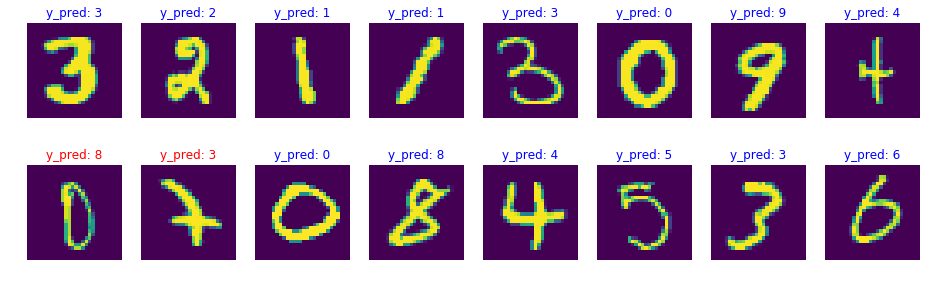

In [18]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred = sess.run(model.predictions, feed_dict={images: batch_xs, model.is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
  p = fig.add_subplot(4, 8, i+1)
  if py == batch_ys[i]:
    p.set_title("y_pred: {}".format(py), color='blue')
  else:
    p.set_title("y_pred: {}".format(py), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')